In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import imageio
from drop_functions import (
    savitzky_golay, 
    remove_isolated, 
    add_boundary_knots, 
    integrate_countour, 
    interpolateNaN,
    fit_ellipse,
    get_ellipse_pts,
    cart_to_pol
)
import PIL
from scipy.interpolate import CubicSpline
import datetime
%matplotlib widget

In [172]:
path2 = r"9кв теневой от 13.09.23_"
files = [os.path.join(path2, name) for name in os.listdir(path2)]
images = []
for file in files:
    with PIL.Image.open(file) as im:
        im = np.asarray(im)[:,:,0]
        images.append(im)
images = images[9:]
time = np.arange(len(images))
# for file in os.listdir(path2)[9:]:
#     stop = file[::-1].find("_")
#     date = file[-stop:-4]
#     h, m, s =  (float(x) for x in date.split("-"))
#     time.append(3600*h + 60 * m + s)
# time = np.array(time)
# time = time - time[0]

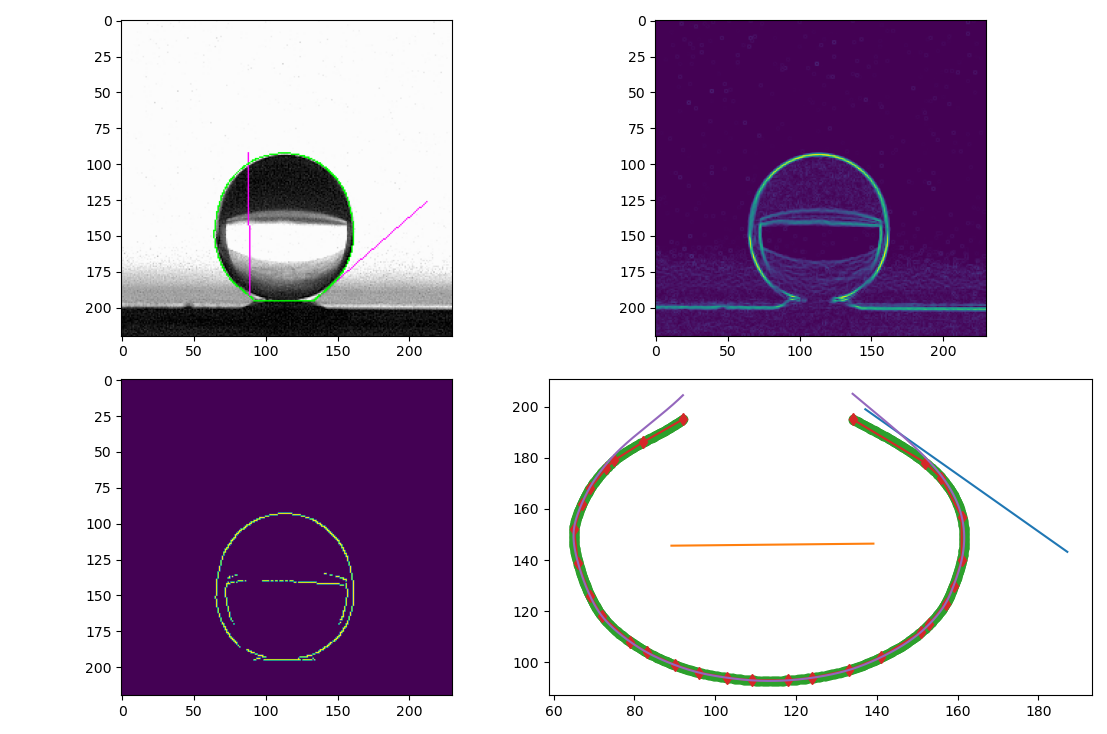

In [334]:
img = images[int(len(images)/9 * 1) + 1]
# img = images[0]
countoured = []
areas3 = []
angles1 = []
angles2 = []
volume = []
height = []
contact_d = []
check = None

for img in images:
    img = images[int(len(images)/9 * 4) + 3]
    
    img = np.rot90(img, k=0).copy()
    img = img[250:470,400:630]
    
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    blur = cv2.GaussianBlur(img, (5,5), 0)

    mask = np.ones_like(img)
    botom_line = 196
    # mask[:,:57] = 0
    # mask[:,230:] = 0
    # mask[184:204,219:] = 0
    mask[botom_line:,:] = 0
    # # mask[184:,:69] = 0
    # mask[167:,:65] = 0
    # mask[167:,221:] = 0
    # mask[180:,:77] = 0
    # mask[180:,213:] = 0
    # mask[158:168,76:91] = 0
    # mask[166:176,190:200] = 0
    # mask[167:,232:] = 0
    grad_x, grad_y = np.gradient(img)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    sobel_x = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT) 
    sobel_y = cv2.Sobel(img, cv2.CV_16S, 0, 1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT) 
    abs_grad_x = cv2.convertScaleAbs(sobel_x)
    abs_grad_y = cv2.convertScaleAbs(sobel_y)
    sobel = np.sqrt(sobel_x.astype(np.float64)**2 + sobel_y.astype(np.float64)**2)
    # sobel = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
 
    canny = cv2.Canny(blur,25,65, 5)
    # canny = (sobel > 500)
    # canny = cv2.Canny(blur,45,69)
    thr = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    # canny =thr
    canny[canny > 0] = 1


    # canny = canny * thr
    # canny = np.ones_like(canny)
    canny = canny * (grad > 45)
    canny = canny * mask
    canny, f = remove_isolated(canny, 9, 5)
    canny, f = remove_isolated(canny, 5, 0)
    # canny, f = remove_isolated(canny, 3, 0)

    canny[botom_line-1,100:123] = 1


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    # canny = cv2.morphologyEx(canny, op=cv2.MORPH_CLOSE, kernel=kernel, iterations=5)

    canny = canny * mask

    points = np.argwhere(np.flip(np.rot90(canny), axis=0))
    hull = cv2.convexHull(points)
    if hull is not None and hull.size > 10:

        peri = cv2.arcLength(hull, True)
        hull = cv2.approxPolyDP(hull, 0.001 * peri, True)
        array = np.array(hull).squeeze()
        dist_id = np.argmax(np.sqrt(np.sum(np.diff(array, axis=0)**2, axis=1 )))
        array2 = np.roll(array, -dist_id-1, axis=0)
        distance = np.cumsum( np.sqrt(np.sum(np.diff(array2, axis=0)**2, axis=1 )) )
        distance = np.insert(distance, 0, 0)/distance[-1]
        cs = CubicSpline(distance, array2, axis=0)
        alpha = np.linspace(0, 1, 1000)
        curve = cs(alpha)


        # first_derivative = np.gradient(curve[:,1])
        # second_derivative = np.gradient(first_derivative)   
        # min_id = np.argmin(first_derivative)
        # if min_id / first_derivative.size > .2:
        #     min_id = 0
        # max_id = np.argmax(first_derivative[min_id:])
        # # print(max_id / first_derivative[min_id:].size)
        # if max_id / first_derivative[min_id:].size < .77:
        #     max_id = first_derivative[min_id:].size

        # ids = np.arange(len(curve[:,1]))
        # ids_cut = ids[min_id:max_id + min_id]
        # curve_cut = curve[min_id:max_id + min_id, 1]
        # if curve_cut.size > 10:
        #     spl = CubicSpline(ids_cut.squeeze(), curve_cut.squeeze(), bc_type="natural")
        #     add_boundary_knots(spl)
        #     curve[:,1] = spl(ids)
        #     cut = np.argwhere(curve[:,1] < botom_line)
        #     curve = curve[cut,:].squeeze()

        # try:
        #     # cut_curve = curve[:100, :]
        #     coeffs = fit_ellipse(*curve.T)
        #     x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
        #     x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi), npts=curve.shape[0])
        #     curve_new = np.array([x, y]).T
        #     curve_new = curve_new[curve_new[:,1] < botom_line,:]
        #     curve_new = np.roll(curve_new, -1, axis=0)
        #     dist_id = np.argmax(np.sqrt(np.sum(np.diff(curve_new, axis=0)**2, axis=1 )))
        #     curve_new = np.roll(curve_new, -dist_id-1, axis=0)
        #     curve = curve_new
        # except:
        #     pass

        if curve.size > 20:
            pad = 15
            samples = 50
            length = 100
            # points = curve[pad:pad+samples,::-1]
            # coeffs = fit_ellipse(*points.T)
            # print(coeffs)
            # x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
            k1, m1 = np.polyfit(*points.T, 1)
            teta1 = 3*np.pi/2 - np.arctan(k1)

            
            if  180 - teta1/np.pi*180 + 180 < 5  or 180 - teta1/np.pi*180 + 180 > 170:
                teta1 = np.nan 
            else:
                # print(teta1/np.pi*180 - 180)
                x00 = int(round(curve[pad,0]))
                x01 = int(round(length * np.cos(teta1) + curve[pad,0]))
                y00 = int(round(curve[pad,1]))
                y01 = int(round(length * np.sin(teta1) + curve[pad,1])) 
                cv2.line(img_color, (x00, y00), (x01, y01), (255,1,255), 1)
            # ax[0,1].scatter(curve[pad:pad+samples,0], curve[pad:pad+samples,1])
            # ax[0,1].scatter(*points.T)
            # print(k1)


            pad = 15
            samples = 50

            length = 100
            points = curve[-(pad+samples)-1:-pad-1,::-1]
            # points = np.sort(points, axis=0)
            # points = points[::-1,:]


            k2, m2 = np.polyfit(*points.T, 1)
            teta2 = -np.arctan(k2) - np.pi/2
            if 180+teta2/np.pi*180 < 5  or 180+teta2/np.pi*180 > 170:
                teta2 = np.nan  
            else:
                x10 = int(round(curve[-pad-1,0]))
                x11 = int(round(length * np.cos(teta2) + curve[-pad-1,0]))
                y10 = int(round(curve[-pad-1,1]))
                y11 = int(round(length * np.sin(teta2) + curve[-pad-1,1]))  
                cv2.line(img_color, (x10, y10), (x11, y11), (255,1,255), 1)
        else:
            teta2 = np.nan
            teta1 = np.nan
        
        angles1.append(180 - teta1/np.pi*180 + 180)

        angles2.append(180+teta2/np.pi*180)
            
        curve_int = curve[:,None,:].astype(np.int32)
        mask = np.zeros_like(img)
        cv2.drawContours(mask, [curve_int], -1, 1, -1)
        volume.append(integrate_countour(mask))
        x0, y0 = curve[0,:]
        x1, y1 = curve[-1,:]
        contact_d.append(np.sqrt((x0 - x1)**2 + (y0 - y1)**2))
        height.append(np.max(curve[:,1]) - np.min(curve[:,1]))
        cv2.drawContours(img_color, [curve_int], -1, (1,255,1), 1)
        countoured.append(img_color)
        areas3.append(cv2.contourArea(curve_int))
    else:
        countoured.append(img_color)
        areas3.append(np.nan)
        angles2.append(np.nan)
        angles1.append(np.nan)
        contact_d.append(np.nan)
        height.append(np.nan)
        volume.append(np.nan)
    break
angles1 = np.array(angles1)
angles2 = np.array(angles2)
height = np.array(height)
contact_d = np.array(contact_d)
volume = np.array(volume)




fig, ax = plt.subplots(2,2)

fig.set_size_inches(11.07,  7.34)
ax[0,0].imshow(img_color)
ax[1,0].imshow(canny)
ax[0,1].imshow(sobel)

first_derivative = np.gradient(curve[:,1])
second_derivative = np.gradient(first_derivative)
# ax[0,1].plot(first_derivative)
min_id = np.argmin(first_derivative)
max_id = np.argmax(first_derivative[min_id:])
ids_cut = np.argwhere(second_derivative > 0)
ids = np.arange(len(curve[:,1]))
ids_cut = ids[min_id:max_id + min_id]
curve_cut = curve[min_id:max_id + min_id, 1]
# ax[0,1].imshow(grad)
# ax[0,1].plot(first_derivative)

spl = CubicSpline(ids_cut.squeeze(), curve_cut.squeeze(), bc_type="natural")
add_boundary_knots(spl)
new_curve = spl(ids)
new_x = curve[:,0][new_curve < 220]
new_ids = ids[new_curve < 220]
new_curve = new_curve[new_curve < 220]
first_derivative = np.gradient(new_curve)
second_derivative = np.gradient(first_derivative)
# ax[0,1].plot(first_derivative)




x = np.linspace(curve[-pad-1,0], curve[-pad-1,0] + 50, 100)
ax[1,1].plot(x, x*k2 + m2)
x = np.linspace(curve[pad,0], curve[pad,0] + 50, 100)
ax[1,1].plot(x, x*k1 + m1)
ax[1,1].plot(*curve.T, marker="o")
ax[1,1].plot(*array2.T, marker="d")
ax[1,1].plot(new_x, new_curve)
fig.tight_layout()


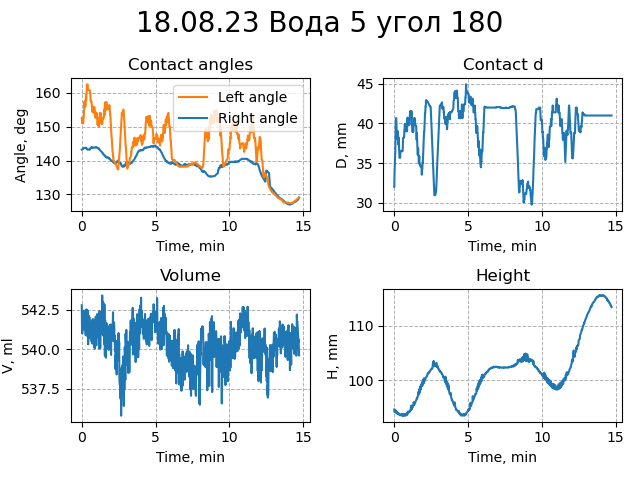

In [328]:

time_min = time / 60
time_cut = 200
time_min_i = time_min[time_min < time_cut]
time_sec = time[time_min < time_cut]
scale = np.array(((122, 99), (497, 422)))
scale = 6/np.sqrt(np.sum((scale[0,:] - scale[1,:])**2))
scale = 1
angles1_i = interpolateNaN(angles1)[time_min < time_cut]
angles2_i = interpolateNaN(angles2)[time_min < time_cut]
contact_d_i = interpolateNaN(contact_d)[time_min < time_cut] * scale
volume_i = interpolateNaN(volume)[time_min < time_cut] * scale**3 * 1e-3
height_i = interpolateNaN(height)[time_min < time_cut] * scale
fig, ax = plt.subplots(2, 2)
fig.suptitle('18.08.23 Вода 5 угол 180', fontsize=20)
# p1, = ax.plot(areas)
angles1_i = savitzky_golay(angles1_i, 15, 0)
angles2_i = savitzky_golay(angles2_i, 15, 0)
contact_d_i = savitzky_golay(contact_d_i, 15, 1)  
# volume_i = savitzky_golay(volume_i, 15, 1)
# height_i = savitzky_golay(height_i, 15, 1)
# contact_d_i = savitzky_golay(contact_d_i, 15, 1)  
p2,= ax[0, 0].plot(time_min_i, angles1_i)
p1,= ax[0, 0].plot(time_min_i, angles2_i)
# p3,= ax.plot(array2[:,0], array2[:,1], marker="o")
# p3,= ax.plot(*curve.T, marker="d")
# ax.plot(dist)
ax[0, 0].set_title("Contact angles")
ax[0, 0].set_xlabel("Time, min")
ax[0, 0].set_ylabel("Angle, deg")
ax[0, 0].grid(True, linestyle = '--', linewidth = 0.7)
# ax.set_xlim(-20,500)
# ax.set_ylim(-10,180)
ax[0, 0].legend(handles=[p1, p2], labels=["Left angle","Right angle"])

ax[0, 1].plot(time_min_i, contact_d_i)
# ax[0, 1].imshow(mask)

ax[0, 1].set_title("Contact d")
ax[0, 1].set_xlabel("Time, min")
ax[0, 1].set_ylabel("D, mm")
ax[0, 1].grid(True, linestyle = '--', linewidth = 0.7)

ax[1, 0].plot(time_min_i, volume_i)
ax[1, 0].set_title("Volume")
ax[1, 0].set_xlabel("Time, min")
ax[1, 0].set_ylabel("V, ml")
ax[1, 0].grid(True, linestyle = '--', linewidth = 0.7)

ax[1, 1].plot(time_min_i, height_i)
ax[1, 1].set_title("Height")
ax[1, 1].set_xlabel("Time, min")
ax[1, 1].set_ylabel("H, mm")
ax[1, 1].grid(True, linestyle = '--', linewidth = 0.7)
fig.tight_layout()


In [325]:
writer = imageio.mimsave("9кв теневой от 13.09.23.mp4", countoured, fps = 25)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (230, 220) to (240, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [329]:
table = np.vstack(
    (
        time_sec,
        angles1_i,
        angles2_i,
        contact_d_i,
        volume_i,
        height_i
    )
)
np.savetxt("9кв теневой от 13.09.23_2.csv", table.T, delimiter=",", fmt="%.6f")

In [187]:
table.T[:10,:]

array([[0.00000000e+00, 9.46218746e+01, 1.32542255e+02, 1.99946609e+00,
        8.06665070e-03, 2.07940513e+00],
       [4.40300000e+00, 9.48436448e+01, 1.33873604e+02, 2.00444345e+00,
        8.78583542e-03, 2.08410577e+00],
       [8.80400000e+00, 9.51634832e+01, 1.34146216e+02, 1.98521648e+00,
        8.07800967e-03, 2.06882050e+00],
       [1.31970000e+01, 9.56449799e+01, 1.34865456e+02, 1.97376686e+00,
        8.21325513e-03, 2.07424868e+00],
       [1.75940000e+01, 9.61251707e+01, 1.35399857e+02, 1.96581687e+00,
        8.20850015e-03, 2.06908881e+00],
       [2.20000000e+01, 9.64505653e+01, 1.35751422e+02, 1.96041671e+00,
        7.83890214e-03, 2.06068577e+00],
       [2.63940000e+01, 9.68643014e+01, 1.35957714e+02, 1.95565140e+00,
        7.87924996e-03, 2.06225830e+00],
       [3.08060000e+01, 9.73124646e+01, 1.33435896e+02, 1.95040748e+00,
        8.00940604e-03, 2.05556917e+00],
       [3.51970000e+01, 9.77772701e+01, 1.32001341e+02, 1.95064806e+00,
        7.96363052e-03, 

In [ ]:
# Вода 3 угол 90 
# img = img[180:,0:230]
# canny[24:175,35:37] = 1
# canny[:10,:] = 0
# canny[239:,:] = 0
# canny[215:,:60] = 0
# canny[:,:35] = 0
# canny[182:,35:44] = 0
# canny[:18,35:43] = 0

In [ ]:
        # first_derivative = np.gradient(curve[:,1])
        # second_derivative = np.gradient(first_derivative)   
        # min_id = np.argmin(first_derivative)
        # if min_id / first_derivative.size > .2:
        #     min_id = 0
        # max_id = np.argmax(first_derivative[min_id:])
        # # print(max_id / first_derivative[min_id:].size)
        # if max_id / first_derivative[min_id:].size < .77:
        #     max_id = first_derivative[min_id:].size

        # ids = np.arange(len(curve[:,1]))
        # ids_cut = ids[min_id:max_id + min_id]
        # curve_cut = curve[min_id:max_id + min_id, 1]
        # if curve_cut.size > 10:
        #     spl = CubicSpline(ids_cut.squeeze(), curve_cut.squeeze(), bc_type="natural")
        #     add_boundary_knots(spl)
        #     curve[:,1] = spl(ids)
        #     cut = np.argwhere(curve[:,1] < botom_line)
        #     curve = curve[cut,:].squeeze()

        # try:
        #     coeffs = fit_ellipse(*curve.T)
        #     x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
        #     x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi), npts=curve.shape[0])
        #     curve_new = np.array([x, y]).T
        #     curve_new = curve_new[curve_new[:,1] < botom_line,:]
        #     curve_new = np.roll(curve_new, -1, axis=0)
        #     dist_id = np.argmax(np.sqrt(np.sum(np.diff(curve_new, axis=0)**2, axis=1 )))
        #     curve_new = np.roll(curve_new, -dist_id-1, axis=0)
        #     curve = curve_new
        # except:
        #     pass